# 03 - Entrainement du Modele de Diffusion (DDPM)

Ce notebook entraine un DDPM (Denoising Diffusion Probabilistic Model)
pour generer des images satellites synthetiques de secheresse.

**Pipeline :**
1. Preparer les images du domaine secheresse (generees par CycleGAN ou simulees)
2. Visualiser le processus de diffusion (ajout progressif de bruit)
3. Initialiser le DDPM (U-Net + scheduler) avec sauvegarde Drive
4. Entrainer (~4-6h sur GPU T4 Colab) avec auto-resume
5. Generer des echantillons et evaluer la qualite visuelle
6. Sauvegarder le modele final dans Drive

In [1]:
"""
Configuration Google Drive pour sauvegarde outputs.
Les notebooks restent sur GitHub, seuls les checkpoints/resultats vont dans Drive.
"""

from google.colab import drive
import os
import sys

# Montage Drive
drive.mount('/content/drive', force_remount=True)

# Chemin racine pour les outputs uniquement
DRIVE_OUTPUTS = "/content/drive/MyDrive/SatelliteGAN-Outputs"

# Creation structure outputs
for subdir in [
    'data/eurosat', 'data/processed_drought',
    'cyclegan/checkpoints', 'cyclegan/generated_images', 'cyclegan/losses',
    'diffusion/checkpoints', 'diffusion/samples', 'diffusion/losses',
    'evaluation/metrics', 'evaluation/comparisons', 'evaluation/figures',
]:
    os.makedirs(f"{DRIVE_OUTPUTS}/{subdir}", exist_ok=True)

print(f"Drive monte : {DRIVE_OUTPUTS}")
print(f"Structure outputs creee")

# Clone du repo GitHub (code source)
if not os.path.exists('/content/SatelliteGAN-Climate-Agriculture'):
    !git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
    !pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

%cd /content/SatelliteGAN-Climate-Agriculture
sys.path.insert(0, '/content/SatelliteGAN-Climate-Agriculture')

print("Code source charge depuis GitHub")
print("Outputs seront sauvegardes dans Drive")

Mounted at /content/drive
Drive monte : /content/drive/MyDrive/SatelliteGAN-Outputs
Structure outputs creee
Cloning into '/content/SatelliteGAN-Climate-Agriculture'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 117 (delta 62), reused 44 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 3.31 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/SatelliteGAN-Climate-Agriculture
Code source charge depuis GitHub
Outputs seront sauvegardes dans Drive


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.config import DEVICE, DIFFUSION, IMAGE_SIZE
from src.dataset import get_agricultural_dataset, split_dataset
from src.preprocessing import (
    get_eval_transform, simulate_drought, tensor_to_numpy
)
from src.diffusion.train import DiffusionTrainer
from src.evaluation.visualization import (
    show_image_grid, show_comparison, plot_training_losses
)

print(f"Device : {DEVICE}")
print(f"Configuration DDPM : {DIFFUSION}")

Device : cuda
Configuration DDPM : {'n_timesteps': 1000, 'schedule': 'linear', 'beta_start': 0.0001, 'beta_end': 0.02, 'base_channels': 64, 'channel_mults': (1, 2, 4), 'n_res_blocks': 2, 'attention_levels': [2], 'batch_size': 16, 'lr': 0.0001, 'n_epochs': 150, 'sampling_steps': 100, 'save_every': 25}


## 1. Preparation des donnees

On entraine le DDPM sur les images du domaine secheresse.

Deux options :
- **Option A** : Utiliser les images transformees par le CycleGAN (meilleur)
- **Option B** : Utiliser les images de secheresse simulee (plus simple)

On utilise l'option B par defaut. Pour l'option A, charger un checkpoint CycleGAN.

In [8]:
from torchvision import transforms

# Charger les images et appliquer la simulation de secheresse
raw_transform = transforms.Resize(IMAGE_SIZE)
raw_dataset = get_agricultural_dataset(transform=raw_transform)
train_set, val_set, _ = split_dataset(raw_dataset)

# Creer le dataset de secheresse
eval_transform = get_eval_transform()

def prepare_drought_dataset(dataset, transform, n_max=None):
    """Prepare les images de secheresse normalisees."""
    images = []
    n = min(len(dataset), n_max) if n_max else len(dataset)

    for i in range(n):
        img, _ = dataset[i]
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = img

        # Appliquer la secheresse
        drought_pil = simulate_drought(img_pil, severity=0.6)
        img_tensor = transform(drought_pil)
        images.append(img_tensor)

    return torch.stack(images)

print("Preparation des images de secheresse...")
train_drought = prepare_drought_dataset(train_set, eval_transform)
print(f"Dataset de secheresse : {train_drought.shape}")

100%|██████████| 94.3M/94.3M [00:00<00:00, 415MB/s]


EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']
Split : train=8400, val=1050, test=1050
Preparation des images de secheresse...
Dataset de secheresse : torch.Size([8400, 3, 64, 64])


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_training_samples.png


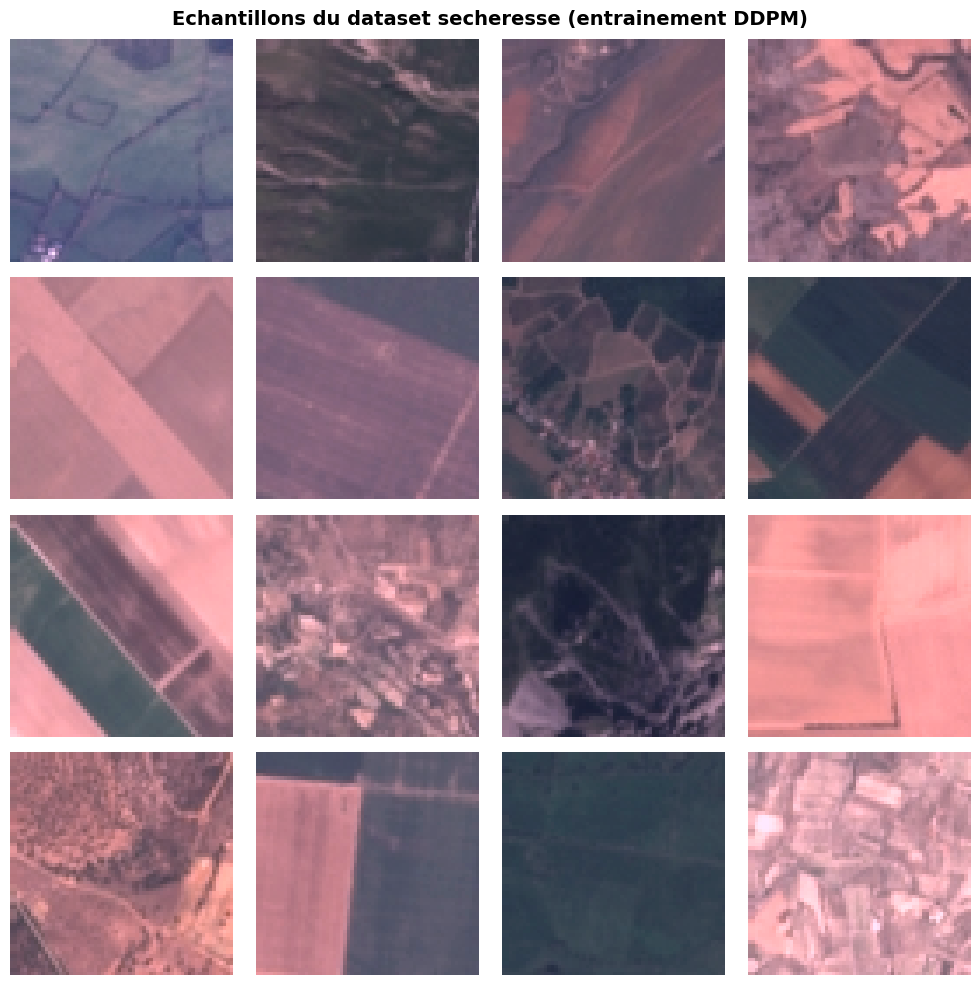

In [9]:
# Visualiser quelques echantillons du dataset d'entrainement
show_image_grid(
    train_drought[:16], n_cols=4,
    title='Echantillons du dataset secheresse (entrainement DDPM)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_training_samples.png"
)

In [10]:
# DataLoader
train_dataset = TensorDataset(train_drought)
train_loader = DataLoader(
    train_dataset,
    batch_size=DIFFUSION['batch_size'],
    shuffle=True,
    drop_last=True
)

print(f"Nombre de batches par epoch : {len(train_loader)}")

Nombre de batches par epoch : 525


## 2. Visualisation du processus de diffusion

Avant d'entrainer, visualisons comment le bruit est ajoute progressivement.
Le processus forward de diffusion ajoute du bruit gaussien a chaque timestep,
jusqu'a obtenir du bruit pur a t=T.

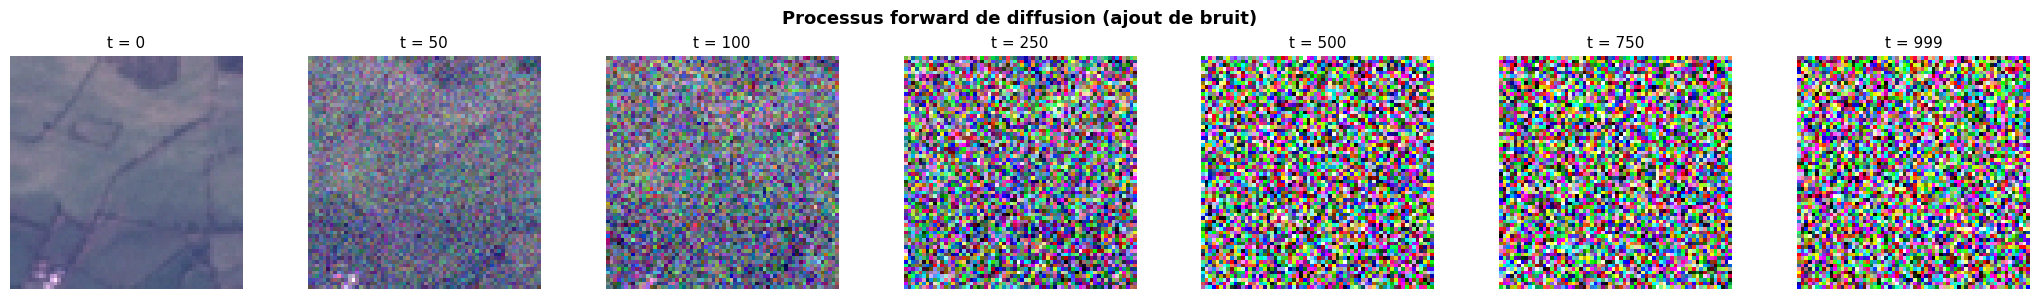

In [11]:
from src.diffusion.scheduler import LinearNoiseScheduler

scheduler = LinearNoiseScheduler(
    n_timesteps=DIFFUSION['n_timesteps'],
    beta_start=DIFFUSION['beta_start'],
    beta_end=DIFFUSION['beta_end']
)

# Prendre une image
sample_img = train_drought[0:1]  # (1, 3, 64, 64)

# Afficher a differents timesteps
timesteps = [0, 50, 100, 250, 500, 750, 999]
fig, axes = plt.subplots(1, len(timesteps), figsize=(3 * len(timesteps), 3))

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t])
    noisy, _ = scheduler.add_noise(sample_img, t_tensor)
    img_np = tensor_to_numpy(noisy[0])
    axes[i].imshow(img_np)
    axes[i].set_title(f't = {t}', fontsize=11)
    axes[i].axis('off')

plt.suptitle('Processus forward de diffusion (ajout de bruit)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/ddpm_forward_process.png",
            dpi=150, bbox_inches='tight')
plt.show()

## 3. Initialisation et entrainement

Le `save_dir` pointe vers Google Drive pour que les checkpoints,
samples generes et historique des pertes survivent aux deconnexions Colab.

Si un checkpoint existe deja dans Drive, l'entrainement reprend
automatiquement depuis le dernier checkpoint (auto-resume).

**Sauvegarde automatique :**
- Checkpoints tous les 25 epochs dans `Drive/SatelliteGAN-Outputs/diffusion/checkpoints/`
- Samples generes dans `Drive/SatelliteGAN-Outputs/diffusion/samples/`
- Historique pertes (JSON) dans `Drive/SatelliteGAN-Outputs/diffusion/losses/`

**Auto-resume :** si l'entrainement est interrompu, relancer cette cellule.
Le trainer detecte le dernier checkpoint et reprend automatiquement.

In [12]:
# Creer le trainer avec sauvegarde Drive
trainer = DiffusionTrainer(
    save_dir=f"{DRIVE_OUTPUTS}/diffusion"  # Checkpoints, samples, pertes -> Drive
)

# Compter les parametres
n_params = sum(p.numel() for p in trainer.model.parameters())
print(f"Parametres du U-Net : {n_params:,}")
print(f"Sauvegarde : {DRIVE_OUTPUTS}/diffusion")

Parametres du U-Net : 15,724,931
Sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion


In [13]:
# Entrainer le modele
# Reduire n_epochs pour un test rapide (ex: 5-10 epochs)
# Pour l'entrainement complet, utiliser DIFFUSION['n_epochs'] (150)
N_EPOCHS = DIFFUSION['n_epochs']  # mettre 5 pour un test rapide

# L'auto-resume detecte les checkpoints existants dans Drive.
# Pour forcer une reprise depuis un checkpoint specifique :
#   history = trainer.train(train_loader, n_epochs=N_EPOCHS,
#                           resume_from=f"{DRIVE_OUTPUTS}/diffusion/checkpoints/epoch_50.pth")

history = trainer.train(train_loader, n_epochs=N_EPOCHS)

Checkpoint charge : epoch 150
Reprise de l'entrainement a l'epoch 150/150
Modele final sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/final.pth


## 4. Courbe de perte

La perte du DDPM est le MSE entre le bruit reel et le bruit predit par le U-Net.
Elle devrait diminuer regulierement au fil des epochs.

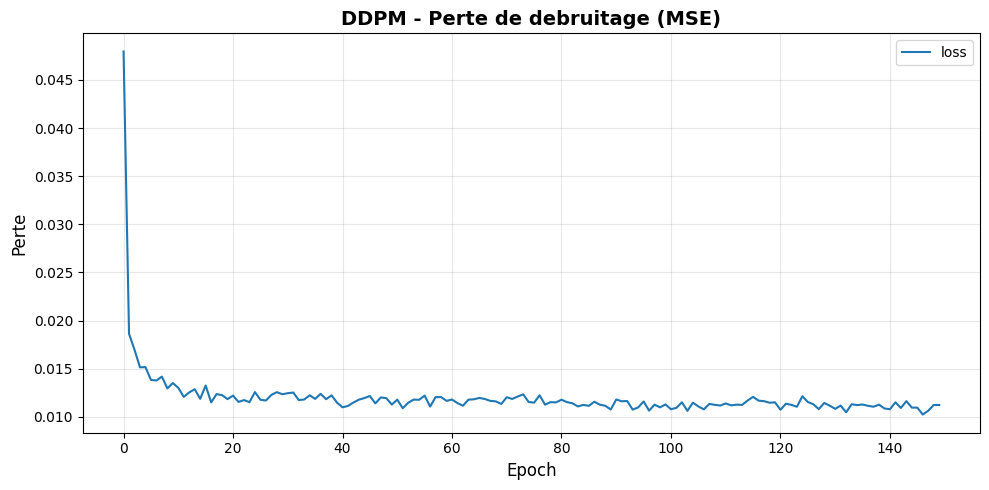

In [14]:
# Afficher les courbes de perte (sauvegardees dans Drive)
plot_training_losses(
    history,
    title='DDPM - Perte de debruitage (MSE)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/figures/ddpm_losses.png"
)

## 5. Generation d'images

On genere des images en partant de bruit pur et en utilisant le processus
reverse de diffusion. Le sampling rapide utilise 50 pas au lieu de 1000
pour un temps de generation raisonnable. L'EMA ameliore la qualite.

Generation d'images (sampling rapide)...


DDIM sampling: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_generated.png


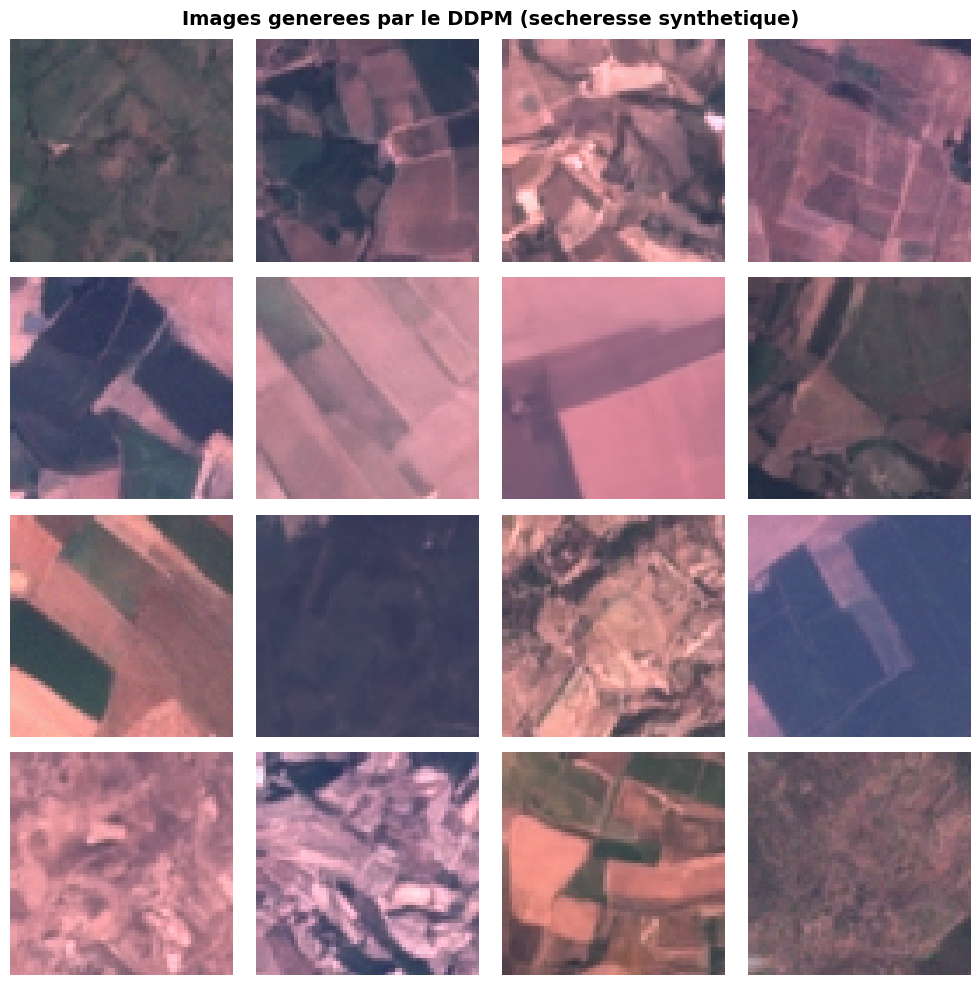

In [15]:
# Generer des images (sampling rapide avec EMA)
print("Generation d'images (sampling rapide)...")
generated = trainer.generate(n_samples=16, use_ema=True, fast=True)

show_image_grid(
    generated.cpu(), n_cols=4,
    title='Images generees par le DDPM (secheresse synthetique)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_generated.png"
)

Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_comparison.png


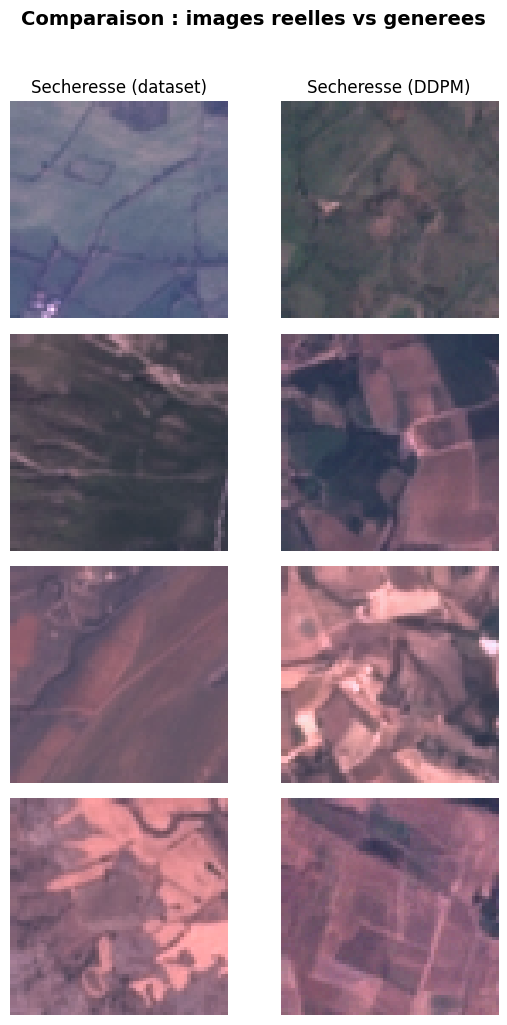

In [16]:
# Comparaison avec les vraies images de secheresse
show_comparison(
    train_drought[:8].cpu(), generated[:8].cpu(),
    n_samples=4,
    labels=('Secheresse (dataset)', 'Secheresse (DDPM)'),
    title='Comparaison : images reelles vs generees',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_comparison.png"
)

## Resume

**Observations :**
- Le DDPM apprend a generer des images satellites de secheresse
- Les images generees montrent des textures et couleurs coherentes
- Le sampling rapide (50 pas) produit des resultats raisonnables
- L'EMA ameliore sensiblement la qualite des generations

**Sauvegardes dans Drive :**
- `diffusion/checkpoints/` : checkpoints toutes les 25 epochs + final.pth
- `diffusion/samples/` : images generees a chaque sauvegarde
- `diffusion/losses/loss_history.json` : historique complet des pertes
- `evaluation/figures/ddpm_losses.png` : courbe de perte
- `evaluation/comparisons/ddpm_generated.png` : grille d'images generees
- `evaluation/comparisons/ddpm_comparison.png` : comparaison reel vs genere

**Prochaine etape :** Evaluation quantitative avec SSIM, PSNR et FID
dans le notebook `04_evaluation_results.ipynb`.